In [2]:
import os, sys, argparse, importlib, time, inspect, json
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader
from importlib import reload
import winsound
import dill, wandb, json,os
import datetime as dt
# if wandblog:
#     !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf

Notebook
GPU detected


In [7]:
with open('../from_config/exp_compare/base.json') as file:
    construct_dict = json.load(file)

construct_dict['group']='grad_tracker'

In [8]:
with tf.device('/cpu:0'):
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model=tf.keras.models.load_model("../trained_models/KHop_base_max_3fsagz9i", options=save_options)
model.compile()
batch_size=512

In [9]:
######
#dependencies
######

cwd=os.getcwd()
def get_lr_schedule(construct_dict):
    schedule  = construct_dict['run_params']['lr_schedule']
    lr_0        = construct_dict['run_params']['learning_rate']
    warm_up        = construct_dict['run_params']['warm_up']
    decay       = construct_dict['run_params']['lr_decay']

    import dev.lr_schedules as lr_module

    lr_generator = getattr(lr_module, schedule)

    lr_schedule  = lr_generator(lr_0, warm_up, decay)()

    return lr_schedule



def get_metrics(metric_name):
    # Returns a list of functions
    import dev.metrics as metrics
    metrics=getattr(metrics, metric_name)
    return metrics


def get_loss_func(name):
    # Return loss func from the loss functions file given a function name
    import dev.loss_funcs as loss_func_module
    loss_func = getattr(loss_func_module, name)
    return loss_func


def get_performance(name):
    # Return performance plotter from the eval_model file given a name
    import dev.eval_model as evals
    performance_plot = getattr(evals, name)
    return performance_plot 

In [16]:
# Setup Log 
n_events=1000
wandblog=construct_dict["wandblog"]
wandblog=0
if wandblog:
    import wandb
    run = wandb.init(project = construct_dict["experiment"], entity = "chri862z", group=construct_dict["group"], config = construct_dict, reinit=True)
#         wandb.run.name = construct_dict['model_name']+'_'+construct_dict['experiment_name']+'_'+str(wandb.run.id)
    wandb.run.name = construct_dict['model_name']+'_'+str(wandb.run.id)
################################################
#   Load dataset                              #
################################################
#load dataset

import dev.testtraindata as dl
print(os.getcwd())
graph_data=dl.graph_data

batch_size=100
epochs=1
os.chdir("C:\\Users\\chris\\Christian\\3YR-UNI\\Bachelor\\IceCube") ######!!!!!!
dataset=graph_data(n_steps=10, n_neighbors=31, restart=False, traintest='mix', i_test=1)
os.chdir('model_eval')


C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\model_eval
Loading mixed data to memory


In [89]:
loader_train = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
#     loader_test = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
loader_val = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

In [99]:
def i_path(x): return tf.zeros_like(x)

In [100]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1, num=m_steps+1)

In [101]:
def interpolate_data(inputx,alphas):
    baseline=i_path(inputx[0])
    alpha=tf.cast(alphas, tf.float64)
    alphas_x = alpha[tf.newaxis, :]
    # alphas_x
    baseline_x = tf.expand_dims(baseline, axis=2)
    input_x = tf.expand_dims(inputx[0], axis=2)
    delta = input_x - baseline_x
    # print(delta)
    inputs = baseline_x +  delta*alphas_x 
    return tf.transpose(inputs, perm=[2,0,1])

In [104]:
out=interpolate_data(inputs, alphas)

In [108]:
loader_train = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
#     loader_test = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
loader_val = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

In [155]:
inputs, targets = next(loader_val)
zenigrad((inputs[0],inputs[1],inputs[2]), targets)

[[<tf.Tensor: shape=(100, 7), dtype=float64, numpy=
  array([[1.40898196e+00, 5.34183837e-01, 6.92300417e-01, 2.92958310e-01,
          4.25534208e-03, 2.21501863e-02, 2.24397176e-02],
         [1.58543616e-01, 6.69630375e-01, 8.04447229e-01, 2.96398310e-01,
          3.84900902e-03, 2.09420741e-02, 1.67451683e-02],
         [9.12502778e-01, 7.41519225e-01, 9.82605578e-01, 1.34532475e-01,
          2.98573445e-03, 5.29343218e-03, 1.52681178e-02],
         [1.26940161e+00, 1.56155956e+00, 7.47990430e-01, 1.73541988e-01,
          5.11705502e-03, 2.39924540e-02, 2.44332355e-02],
         [4.27625806e-01, 7.08362202e-01, 6.68798670e-01, 1.25311591e-01,
          2.60829244e-03, 8.71392033e-03, 1.16943790e-02],
         [2.14937510e+00, 2.23265919e+00, 1.06983562e+00, 3.08536319e-01,
          2.13310813e-03, 1.64821829e-02, 1.69897778e-02],
         [1.27979592e+00, 7.49737951e-01, 3.89262881e-01, 5.70791064e-02,
          5.19089041e-03, 2.65584447e-02, 3.80412496e-02],
         [1.54244

In [ ]:
rawl, gradsl =[], [], [], [], []
tot_time=0
current_batch = 0
current_epoch = 1
loss          = 0
lowest_loss   = np.inf
early_stop    = 1
early_stop_counter    = 0
pbar          = tqdm(total = loader_train.steps_per_epoch, position=0, leave = True)
start_time    = time.time()
summarylist=[]
for batch in loader_train:
    inputs, targets = batch
#         out             = train_step(inputs, targets)
#         loss           += out
    if current_epoch==1 and current_batch==0:
        model.summary()
        if wandblog:
            summary=model.summary(print_fn=summarylist.append)
            table=wandb.Table(columns=["Layers"])
            for s in summarylist:
                table.add_data(s)
            wandb.log({'Model summary': table})
    current_batch  += 1
    pbar.update(1)
    pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")



    rawl.append([rawE,rawzeni,rawazi,rawzenisig,rawazisig])
    gradsl.append([gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig])
    recol.append(reco)
    truel.append(true)
    inputl.append(inp)

In [ ]:
@tf.function
def integrated_gradients(inputs, targets, m_steps=50, batch_size=512):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_data(inputs, alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = zenigrad(inputs
        
        images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (inputs) * avg_gradients

  return integrated_gradients

In [206]:
@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
# @tf.function(experimental_relax_shapes = True)
def grads(inputs, targets):
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        pred = model(inputs, training=False)# needs to be under the gradient tape to be tracked
    grads = tape.gradient(pred, inputs[0])
    return grad

In [222]:
# @tf.function
def integrated_gradients(inputs, targets, m_steps=50, batch_size=100):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)

    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float64, size=m_steps)

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    # 2. Generate interpolated inputs between baseline and input.
    interpolated = interpolate_data(inputs, alphas)
    gradl=[]
    for i in range(m_steps):
        a=grads((interpolated[i],inputs[1],inputs[2]), targets)
        b=tf.reduce_sum(a, axis=0)
        print(b)
        c=tf.math.segment_sum(b, inputs[2])
        gradl.append(c)
    
    return tf.concat(gradl, axis=1)

In [223]:
a =integrated_gradients(inputs,targets)
np.shape(a) 

tf.Tensor(
[[[1.56622233e+01 1.29015876e+01 1.63540724e+01 ... 6.47873585e-02
   2.76186375e-01 4.04198850e-01]
  [7.62013931e+00 8.71557718e+00 8.87783282e+00 ... 4.81648207e-02
   2.67375131e-01 1.94408245e-01]
  [1.32228002e+01 1.37003254e+01 1.16188822e+01 ... 4.91229177e-02
   3.13369032e-01 2.35843976e-01]
  ...
  [4.56468881e+00 6.70389388e+00 7.81624811e+00 ... 4.06627684e-02
   2.17419281e-01 2.14560171e-01]
  [1.38233418e+01 1.64646827e+01 1.75315309e+01 ... 5.97384717e-02
   3.87345295e-01 4.12833067e-01]
  [1.11348175e+01 1.37589293e+01 1.59044968e+01 ... 4.73419933e-02
   2.95836580e-01 2.70345857e-01]]

 [[3.20231983e+01 3.40215887e+01 4.97322657e+01 ... 1.00694840e-01
   5.59739771e-01 5.21237835e-01]
  [9.06036937e+00 1.49592167e+01 1.57094134e+01 ... 1.07196653e-01
   6.05491106e-01 3.37519585e-01]
  [1.67255894e+01 2.03414692e+01 3.09934392e+01 ... 9.29141210e-02
   4.99877124e-01 4.38234299e-01]
  ...
  [1.53690104e+01 1.90312590e+01 2.34799384e+01 ... 8.27433217e-02

InvalidArgumentError: segment_ids should be the same size as dimension 0 of input. [Op:SegmentSum]

In [ ]:
grad=

In [204]:
np.shape(zenigrad((inter[0],inputs[1],inputs[2]), targets))

(10, 5, 100, 7)

In [205]:
tf.reduce_mean(a, axis=0)

<tf.Tensor: shape=(5, 100, 7), dtype=float64, numpy=
array([[[1.56622233e+00, 1.29015876e+00, 1.63540724e+00, ...,
         6.47873585e-03, 2.76186375e-02, 4.04198850e-02],
        [7.62013931e-01, 8.71557718e-01, 8.87783282e-01, ...,
         4.81648207e-03, 2.67375131e-02, 1.94408245e-02],
        [1.32228002e+00, 1.37003254e+00, 1.16188822e+00, ...,
         4.91229177e-03, 3.13369032e-02, 2.35843976e-02],
        ...,
        [4.56468881e-01, 6.70389388e-01, 7.81624811e-01, ...,
         4.06627684e-03, 2.17419281e-02, 2.14560171e-02],
        [1.38233418e+00, 1.64646827e+00, 1.75315309e+00, ...,
         5.97384717e-03, 3.87345295e-02, 4.12833067e-02],
        [1.11348175e+00, 1.37589293e+00, 1.59044968e+00, ...,
         4.73419933e-03, 2.95836580e-02, 2.70345857e-02]],

       [[3.20231983e+00, 3.40215887e+00, 4.97322657e+00, ...,
         1.00694840e-02, 5.59739771e-02, 5.21237835e-02],
        [9.06036937e-01, 1.49592167e+00, 1.57094134e+00, ...,
         1.07196653e-02, 6.054

In [202]:
def train_model(construct_dict, n_events):
    """
    Train a model given a construction dictionairy
    """

    # Setup Log 
    wandblog=construct_dict["wandblog"]
    wandblog=0
    if wandblog:
        import wandb
        run = wandb.init(project = construct_dict["experiment"], entity = "chri862z", group=construct_dict["group"], config = construct_dict, reinit=True)
#         wandb.run.name = construct_dict['model_name']+'_'+construct_dict['experiment_name']+'_'+str(wandb.run.id)
        wandb.run.name = construct_dict['model_name']+'_'+str(wandb.run.id)
    ################################################
    #   Load dataset                              #
    ################################################
    #load dataset
#     os.chdir('../model_eval')
    os.chdir("C:\\Users\\chris\\Christian\\3YR-UNI\\Bachelor\\IceCube\\from_config") ######!!!!!!
#     import dev.testdata as dl
#     print(os.getcwd())
#     graph_data=dl.graph_data
    
#     batch_size=100
#     epochs=1
    
#     dataset=graph_data(restart=False, features=["dom_x", "dom_y", "dom_z", "dom_time", "charge_log10", "width", "rqe"], 
#         targets= ["energy_log10", "zenith","azimuth", "event_no"],
#         transform_path='../db_files/dev_lvl7/transformers.pkl',
#         db_path= '../db_files/dev_lvl7/dev_lvl7_mu_nu_e_classification_v003.db', i_test=5)
    loader_train = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
#     loader_test = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
    loader_val = DisjointLoader(dataset, batch_size=batch_size, epochs=1)


     ###############################################
    #   Setup other run params                     #
    ################################################

    print('check')
    ################################################
    #   Setup model, loss, lr schedule and metrics #
    ################################################

    # Get model, metrics, lr_schedule and loss function
    model_path='trained_models'
    loss_func             = get_loss_func(construct_dict['run_params']['loss_func'])
    metrics               = get_metrics(construct_dict['run_params']['metrics'])
    performance_plot      = get_performance(construct_dict['run_params']['performance_plot'])
    lr_schedule          = get_lr_schedule(construct_dict)



    # Learning rate and optimizer
    learning_rate            = next(lr_schedule)
    opt           = Adam(learning_rate)

    ################################################
    #   Set up TF functions and validation step   #
    ################################################


    # Define training function
    @tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = model(inputs, training = True)
            targets     = tf.cast(targets, tf.float32)
            loss        = loss_func(predictions, targets)
            loss       += sum(model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    @tf.function(input_signature = loader_val.tf_signature(), experimental_relax_shapes = True)
    def test_step(inputs, targets):
        predictions = model(inputs, training = False)
        targets     = tf.cast(targets, tf.float32) 
        out         = loss_func(predictions, targets)

        return predictions, targets, out


    def validation(loader):
        loss = 0
        prediction_list, target_list = [], []
        for batch in loader:
            inputs, targets = batch
            predictions, targets, out = test_step(inputs, targets)
            loss           += out
            
            prediction_list.append(predictions)
            target_list.append(targets)
        
        y_reco  = tf.concat(prediction_list, axis = 0)
        y_true  = tf.concat(target_list, axis = 0)
        y_true  = tf.cast(y_true, tf.float32)

        loss, loss_from = loss_func(y_reco, y_true, re=True)
        
        energy, e_old, alpha, zeni, azi= metrics(y_reco, y_true)
        
        return loss, loss_from, [energy, e_old, alpha, zeni, azi]

    # Define grad tracking function
    @tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
#     @tf.function(experimental_relax_shapes = True)
    def gradient_importance(inputs, targets):
        
        with tf.GradientTape() as tape:
            tape.watch(inputs[0])
            predE = model(inputs, training=False)[:,0]# needs to be under the gradient tape to be tracked
        grads = tape.gradient(predE, inputs[0])
        rawE=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
        gradsE=tf.math.segment_mean(tf.math.abs(rawE), inputs[2], name=None)
#         tf.print('Energy')
        with tf.GradientTape() as tape:
            tape.watch(inputs[0])
            predzeni = model(inputs, training=False)[:,1]
        grads = tape.gradient(predzeni, inputs[0])
        rawzeni=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
        gradszeni=tf.math.segment_mean(tf.math.abs(rawzeni), inputs[2], name=None)
#         tf.print('Zeni')
        with tf.GradientTape() as tape:
            tape.watch(inputs[0])
            predazi = model(inputs, training=False)[:,2]
        grads = tape.gradient(predazi, inputs[0])
        rawazi=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
        gradsazi=tf.math.segment_mean(tf.math.abs(rawazi), inputs[2], name=None)
#         tf.print('Azi')
        with tf.GradientTape() as tape:
            tape.watch(inputs[0])
            predzenisig = model(inputs, training=False)[:,3]
        grads = tape.gradient(predzenisig, inputs[0])
        rawzenisig=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
        gradszenisig=tf.math.segment_mean(tf.math.abs(rawzenisig), inputs[2], name=None)
#         tf.print('zenisig')
        with tf.GradientTape() as tape:
            tape.watch(inputs[0])
            predazisig = model(inputs, training=False)[:,4]
        grads = tape.gradient(predazisig, inputs[0])
        rawazisig=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
        gradsazisig=tf.math.segment_mean(tf.math.abs(rawazisig), inputs[2], name=None)
#         tf.print('Azisig')
        predictions = model(inputs, training=False)
#         predictions=grads
#         tf.print('exit')
#         return [rawE,rawzeni,rawazi,rawzenisig,rawazisig], [gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig], inputs, targets, predictions
        return rawE,rawzeni,rawazi,rawzenisig,rawazisig, gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig, targets, predictions, inputs

    ################################################
    #  Train Model                                 #      
    ################################################
    rawl, gradsl, recol, truel, inputl=[], [], [], [], []
    tot_time=0
    current_batch = 0
    current_epoch = 1
    loss          = 0
    lowest_loss   = np.inf
    early_stop    = 1
    early_stop_counter    = 0
    pbar          = tqdm(total = loader_train.steps_per_epoch, position=0, leave = True)
    start_time    = time.time()
    summarylist=[]
    for batch in loader_train:
        inputs, targets = batch
#         out             = train_step(inputs, targets)
#         loss           += out
        if current_epoch==1 and current_batch==0:
            model.summary()
            if wandblog:
                summary=model.summary(print_fn=summarylist.append)
                table=wandb.Table(columns=["Layers"])
                for s in summarylist:
                    table.add_data(s)
                wandb.log({'Model summary': table})
        current_batch  += 1
        pbar.update(1)
        pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")
        
        grad_dict={'energy':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'dom_time':1,
                      'charge_log10':1,
                      'width':1,
                        'rqe':1},
                       'zenith':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'dom_time':1,
                      'charge_log10':1,
                      'width':1,
                        'rqe':1},
                      'azimuth':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'dom_time':1,
                      'charge_log10':1,
                      'width':1,
                        'rqe':1},
                      'sig_zeni':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'dom_time':1,
                      'charge_log10':1,
                      'width':1,
                        'rqe':1},
                      'sig_azi':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'dom_time':1,
                      'charge_log10':1,
                      'width':1,
                        'rqe':1}}
        keys=list(grad_dict.keys())
        feats=list(grad_dict[keys[0]].keys())
#         for j in range(len(keys)):  
        rawE,rawzeni,rawazi,rawzenisig,rawazisig, gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig, true, reco, inp=gradient_importance(inputs, targets)
#         print('Exited')
        rawl.append([rawE,rawzeni,rawazi,rawzenisig,rawazisig])
        gradsl.append([gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig])
        recol.append(reco)
        truel.append(true)
        inputl.append(inp)
            
#         return rawl, gradsl, recol, truel, inputl
        
    print('Set return')
    return rawl, gradsl, recol, truel, inputl
    

In [112]:
raw, grad, reco, true, inputs=train_model(construct_dict, 1000)

check


Model: "k_hop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
sg_conv (SGConv)             multiple                  8360      
_________________________________________________________________
sg_conv_1 (SGConv)           multiple                  24000     
_________________________________________________________________
graph_sage_conv (GraphSageCo multiple                  6480      
_________________________________________________________________
graph_sage_conv_1 (GraphSage multiple                  25760     
_________________________________________________________________
global_max_pool (GlobalMaxPo multiple                  0         
_________________________________________________________________
global_avg_pool (GlobalAvgPo multiple                  0     

In [7]:
# [rawE,rawzeni,rawazi,rawzenisig,rawazisig], 
# [gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig], targets, predictions, inputs

In [183]:
outputs=['energy_log10', 'zenith', 'azimuth', 'zenith_sig', 'azimuth_sig']
features=["dom_x", "dom_y", "dom_z", "dom_time", "charge_log10", "width", "rqe"]

In [10]:
#split to events
E_grads=[]
z_grads=[]
a_grads=[]
zs_grads=[]
as_grads=[]
event_feats=[]
for i in tqdm(range(len(raw))):
    _, idx =np.unique(inputs[i][2].numpy(), return_index=True)
#     grad_event=[]
    for j in range(len(raw[0])):
        raw_g = np.split(raw[i][j].numpy(),  idx[1:])
        if j==0:
            E_grads.append(raw_g)
        if j==1:
            z_grads.append(raw_g)
        if j==2:
            a_grads.append(raw_g)
        if j==3:
            zs_grads.append(raw_g)
        if j==4:
            as_grads.append(raw_g)
#     event_raw_grads1.append(raw_g)
    feat =  np.split(inputs[i][0].numpy(), idx[1:])
#     feat=np.vstack(feat)
    event_feats.append(feat)
event_feats=np.hstack(event_feats)

E_grads=np.hstack(E_grads)
z_grads=np.hstack(z_grads)
a_grads=np.hstack(a_grads)
zs_grads=np.hstack(zs_grads)
as_grads=np.hstack(as_grads)

In [217]:
recol  = tf.concat(reco, axis = 0).numpy()
truel  = tf.concat(true, axis = 0)
truel  = tf.cast(truel, tf.float32).numpy()
out_pred=[output+'_pred' for output in outputs]
out_true=[output for output in outputs[:3]]
re_true=np.hstack([np.array(truel), np.array(recol)])
df_all=pd.DataFrame(re_true, columns=out_true+['event_no']+out_pred)
for col in out_true:
    df_all[col+'_res']=abs(df_all[col]-df_all[col+'_pred'])
gav  = tf.concat(grad, axis = 1).numpy()
for i in range(len(gav)):
    for j in range(len(gav[0][0])):
        df_all[outputs[i]+'_'+features[j]+'_grad']=gav[i][:,j]




In [1]:
# df_all

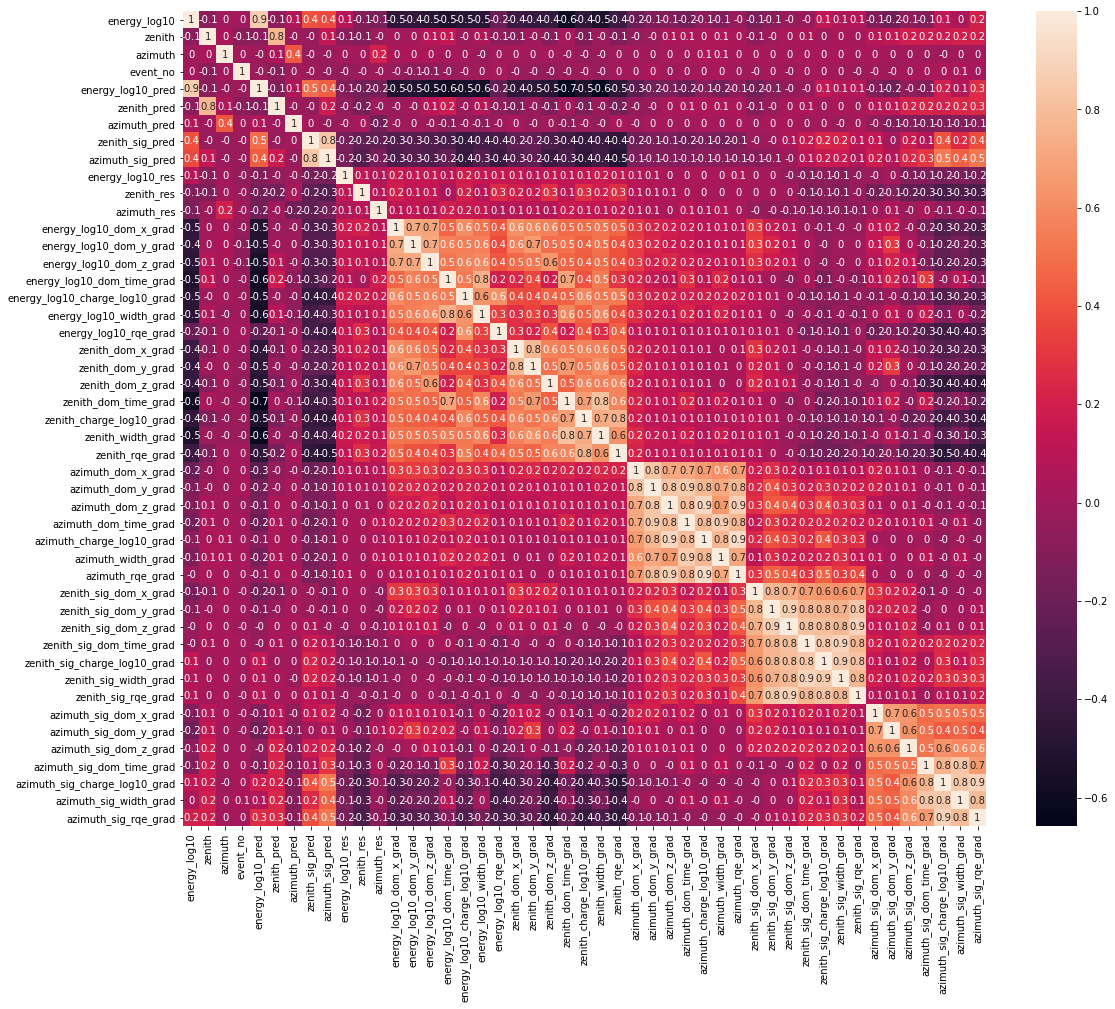

In [219]:
fig, ax = plt.subplots(figsize=(18,15))
corr=df_all.corr()
ax=sns.heatmap(corr, ax=ax, annot=np.round(corr,1))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

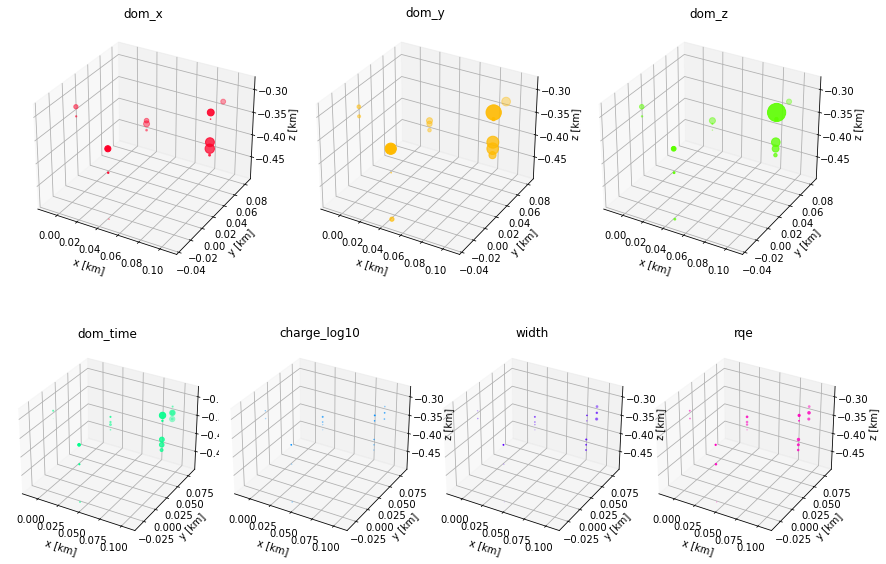

In [12]:
# %matplotlib notebook
%matplotlib inline
k=15
ev, E=event_feats[k], E_grads[k]

axd = plt.figure(figsize=(15,10), constrained_layout=False).subplot_mosaic(
    """
    111122223333
    444555666777
    """
,subplot_kw={"projection": "3d"})
features=["dom_x", "dom_y", "dom_z", "dom_time", "charge_log10", "width", "rqe"]

import matplotlib.cm as mplcm
import matplotlib.colors as colors
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=6)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i in range(7):
    i_s=str(i+1)
    axd[i_s].scatter(ev[:,0],ev[:,1], ev[:,2], c=scalarMap.to_rgba(i), s=(abs(E[:,i])*100))
    axd[i_s].set(xlabel='x [km]', ylabel='y [km]', zlabel='z [km]', title=features[i])

In [13]:
# [rawE,rawzeni,rawazi,rawzenisig,rawazisig], 
# [gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig], targets, predictions, inputs

In [14]:
# split to all
all_grads=[]
all_feats=[]
for i in tqdm(range(len(raw))):
    _, idx =np.unique(inputs[i][2].numpy(), return_index=True)
#     grad_event=[]
    for j in range(len(raw[0])):
        raw_g1 = np.split(raw[i][j].numpy(),  idx[1:])
        raw_g=np.vstack(raw_g1)
        all_grads.append(raw_g)
#     event_raw_grads1.append(raw_g)
    feat =  np.split(inputs[i][0].numpy(), idx[1:])
    feat=np.vstack(feat)
    all_feats.append(feat)
all_feats=np.vstack(all_feats)
all_grads=np.vstack(all_grads)
# E_grads=np.hstack(E_grads)


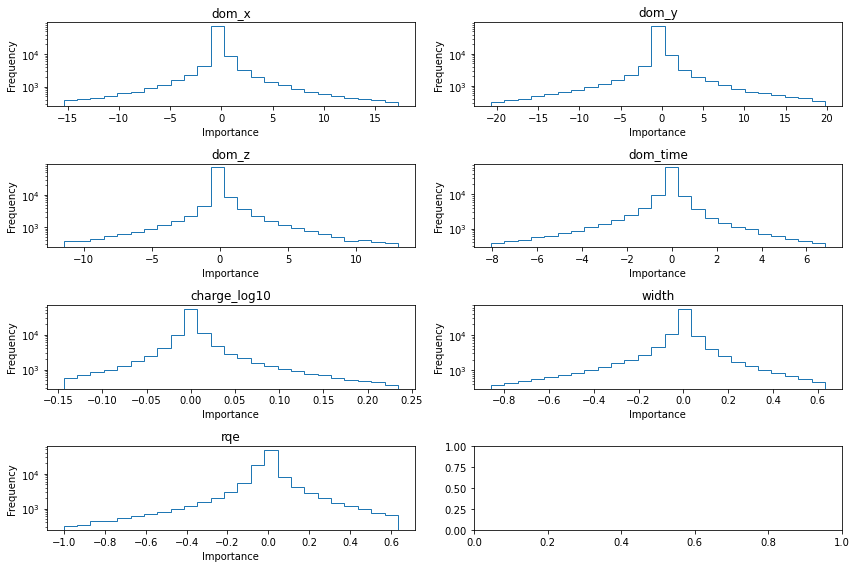

In [15]:
fig,ax=plt.subplots(ncols=2, nrows=4, figsize=(12,8))
ax=ax.flatten()
for i in range(7):
    ax[i].hist(all_grads[:,i], bins=25, histtype='step', range=(np.percentile(all_grads[:,i], 5),np.percentile(all_grads[:,i], 95)))
    ax[i].set(xlabel='Importance', ylabel='Frequency', title=features[i], yscale='log')
    
fig.tight_layout()

In [16]:
# split to all
all_gradsn=[]
for i in tqdm(range(len(raw))):
    _, idx =np.unique(inputs[i][2].numpy(), return_index=True)
#     grad_event=[]
    for j in range(len(raw[0])):
        raw_g1 = np.split(raw[i][j].numpy(),  idx[1:])
        for k in range(len(raw_g1)):
            raw_g1[k]=raw_g1[k]/(np.sum(np.abs(raw_g1[k])))
        raw_g=np.vstack(np.abs(raw_g1))
        all_gradsn.append(raw_g)
all_gradsn=np.vstack(all_gradsn)
# E_grads=np.hstack(E_grads)


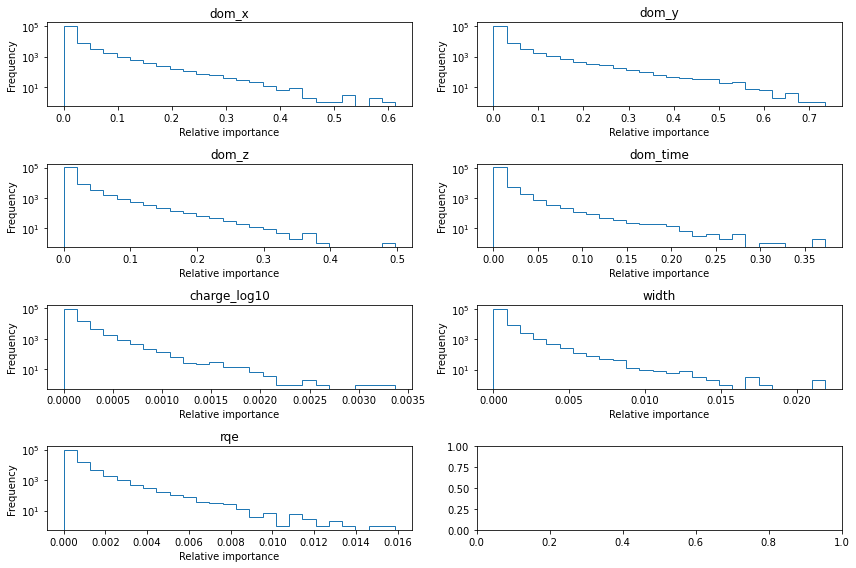

In [17]:
fig,ax=plt.subplots(ncols=2, nrows=4, figsize=(12,8))
ax=ax.flatten()
for i in range(7):
    ax[i].hist(all_gradsn[:,i], bins=25, histtype='step', range=(0,np.max(all_gradsn[:,i])))
    ax[i].set(xlabel='Relative importance', ylabel='Frequency', title=features[i], yscale='log')
    
fig.tight_layout()

In [18]:
import pandas as pd
allfeatdf=pd.DataFrame(all_feats)
allfeatdf.columns=features

In [126]:
# import seaborn as sns
# pl = sns.pairplot(allfeatdf.iloc[:10000], diag_kind='kde', corner=True,
#             x_vars=features[:5], y_vars=features)
# pl.map_lower(sns.kdeplot, levels=4, color=".2")

In [90]:
featg=[feat+'_grad' for feat in features]
dfE=pd.DataFrame(np.vstack(E_grads), columns=featg)
# dfE=dfE[dfE]
for col in dfE.columns:
    dfE=dfE.query(f"{col} != 0")
    dfEfeat=pd.concat([dfE, allfeatdf], axis=1, join='inner')
dfz=pd.DataFrame(np.vstack(z_grads), columns=featg)
for col in dfz.columns:
    dfz=dfz.query(f"{col} != 0")
    dfzfeat=pd.concat([dfz, allfeatdf], axis=1, join='inner')
dfa=pd.DataFrame(np.vstack(a_grads), columns=featg)
for col in dfa.columns:
    dfa=dfa.query(f"{col} != 0")
    dfafeat=pd.concat([dfa, allfeatdf], axis=1, join='inner')
dfzs=pd.DataFrame(np.vstack(zs_grads), columns=featg)
dfas=pd.DataFrame(np.vstack(as_grads), columns=featg)
for col in dfzs.columns:
    dfzs=dfzs.query(f"{col} != 0")
    dfzsfeat=pd.concat([dfzs, allfeatdf], axis=1, join='inner')
dfa=pd.DataFrame(np.vstack(a_grads), columns=featg)
for col in dfas.columns:
    dfas=dfas.query(f"{col} != 0")
    dfasfeat=pd.concat([dfas, allfeatdf], axis=1, join='inner')

In [127]:
# plE = sns.pairplot(dfE, diag_kind='kde', corner=True,
#             x_vars=featg, y_vars=featg)
# # plE.map_lower(sns.kdeplot, levels=4, color=".2")

In [128]:
# plE = sns.pairplot(dfEfeat, diag_kind='kde', corner=True, x_vars=features[:-2]+featg[:-2], y_vars=features[:-2]+featg[:-2])

In [129]:
# plE = sns.pairplot(dfEfeat, diag_kind='kde', corner=True, x_vars=features, y_vars=featg)

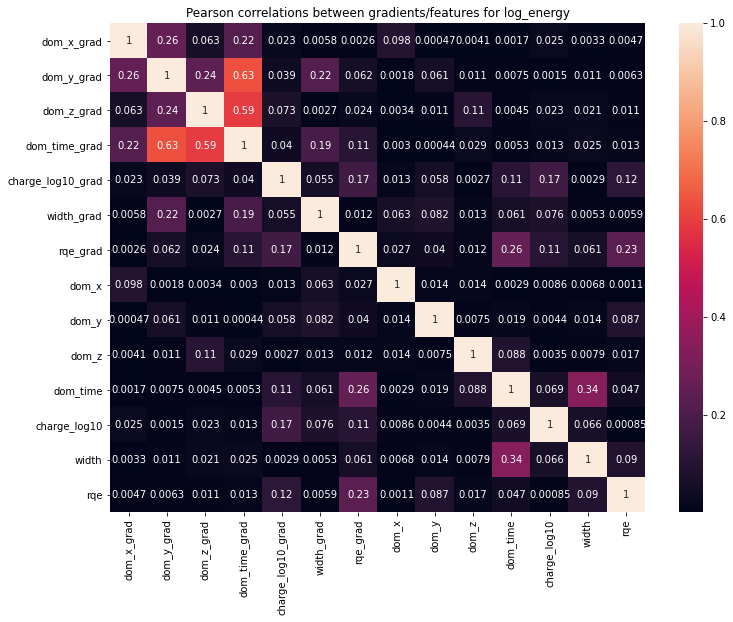

In [125]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfEfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for log_energy')
fig.savefig('../../figs_thesis/corr_gradfeat_zekappa.pdf')

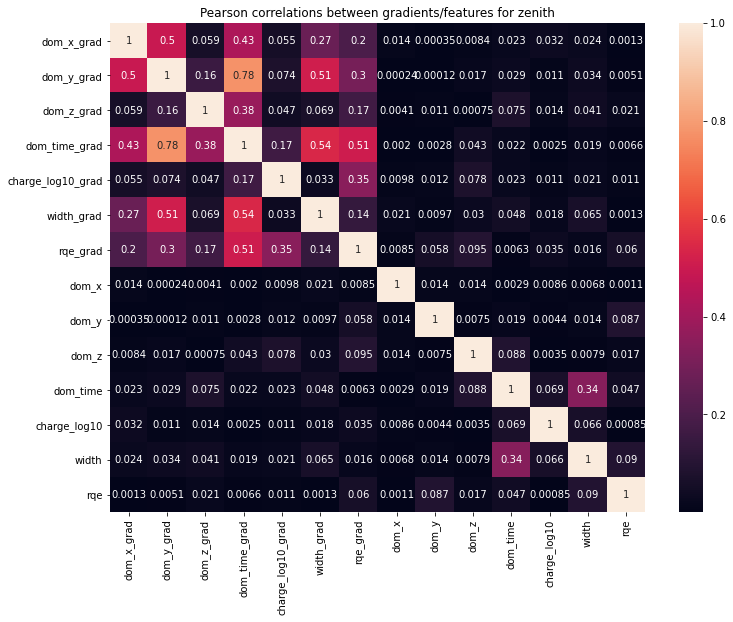

In [123]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfzfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for zenith')
fig.savefig('../../figs_thesis/corr_gradfeat_ze.pdf')

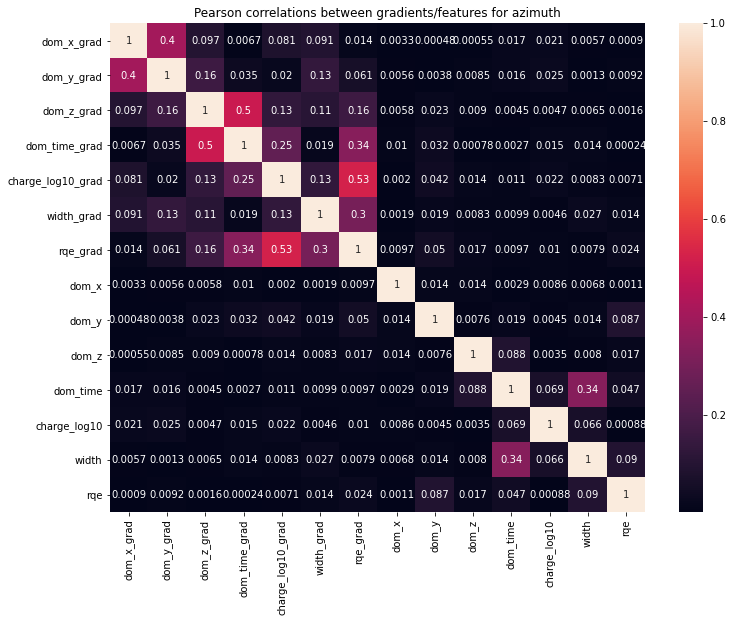

In [124]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfafeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for azimuth')
fig.savefig('../../figs_thesis/corr_gradfeat_azkappa.pdf')

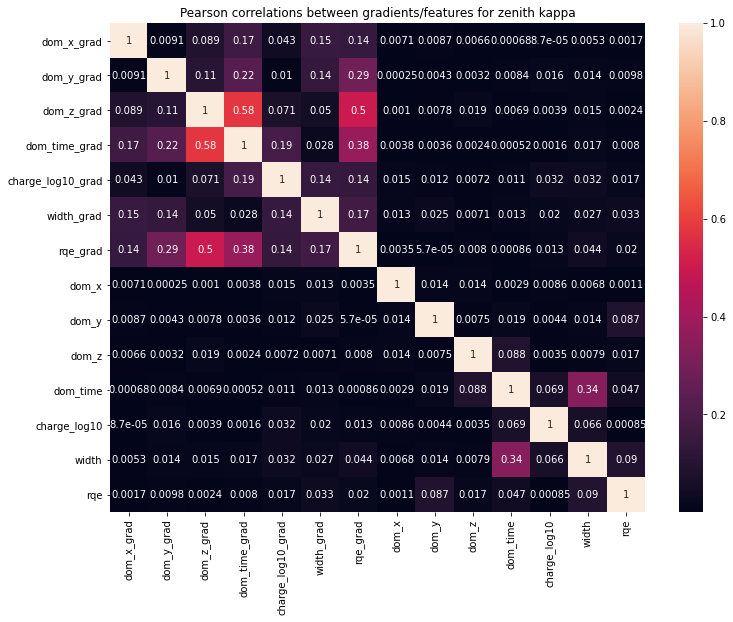

In [122]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfzsfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for zenith kappa')
fig.savefig('../../figs_thesis/corr_gradfeat_zekappa.pdf')

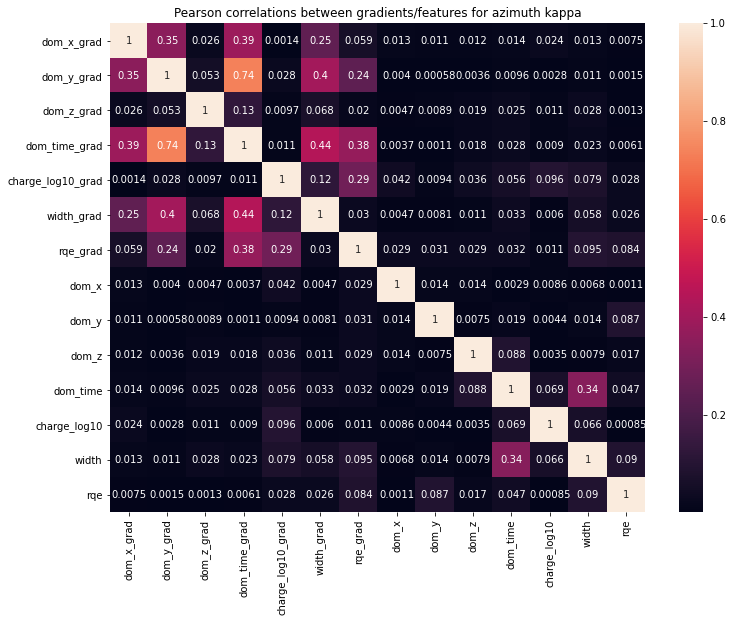

In [121]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfasfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for azimuth kappa')
fig.savefig('../../figs_thesis/corr_gradfeat_azkappa.pdf')

In [109]:
mask = np.zeros_like(dfasfeat.corr())
mask[np.triu_indices_from(mask)] = True
mask[:,-7:]=True

In [ ]:
plz = sns.pairplot(dfz, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# plz.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
pla = sns.pairplot(dfa, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# pla.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
plzs = sns.pairplot(dfzs, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# plzs.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
plas = sns.pairplot(dfas, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# plas.map_lower(sns.kdeplot, levels=4, color=".2")

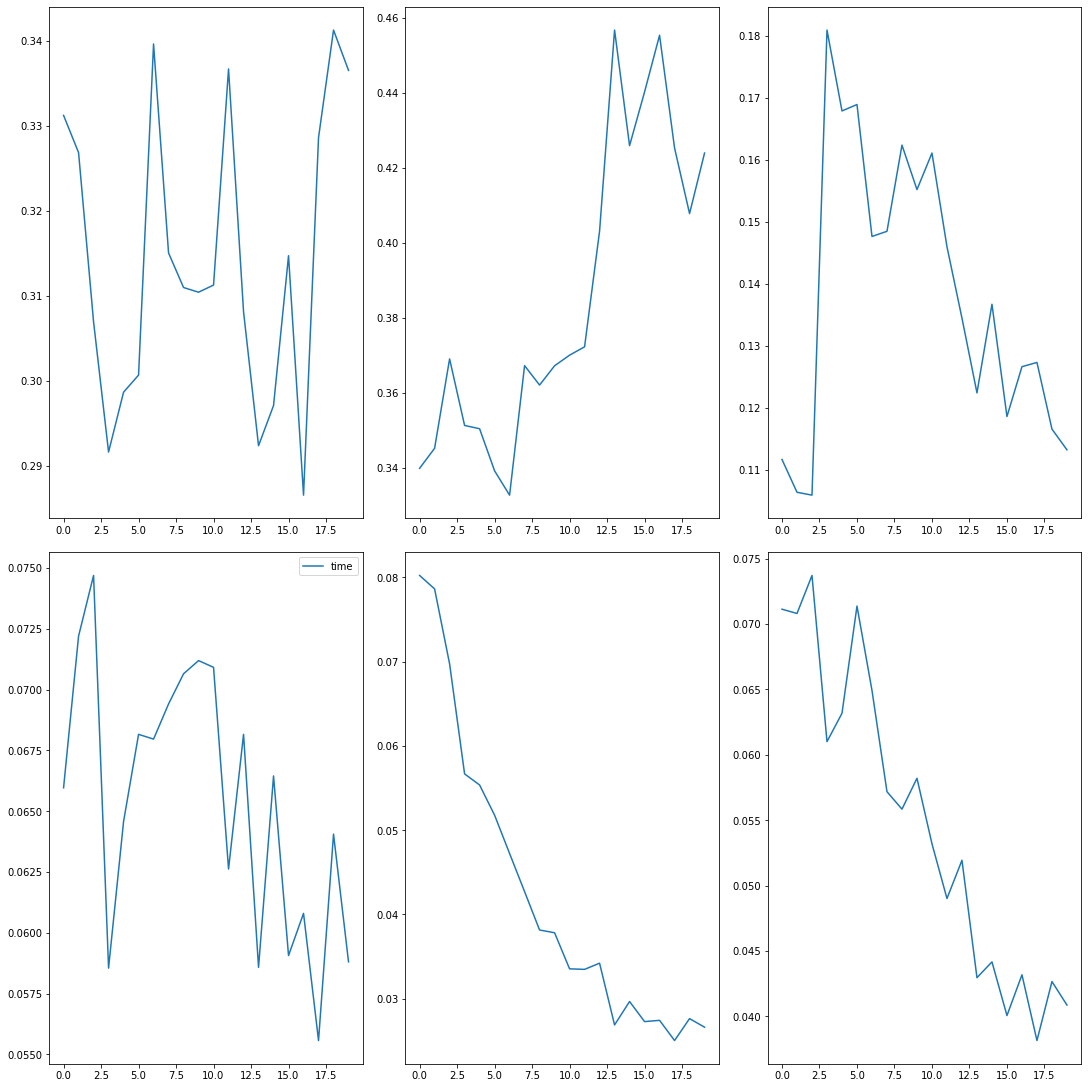

In [31]:
domx=summary[:,0]

ax = plt.figure(constrained_layout=True, figsize=(15,15)).subplot_mosaic(
    [['dom_x', 'dom_y', 'dom_z'],
    ['time', 'charge', 'SRT']])

ax['dom_x'].plot(summary[:,0],label='dom_x')
ax['dom_y'].plot(summary[:,1], label='dom_y')
ax['dom_z'].plot(summary[:,2], label='dom_z')
ax['time'].plot(summary[:,3], label='time')
ax['charge'].plot(summary[:,4], label='charge')
ax['SRT'].plot(summary[:,5], label='SRT')
plt.legend()

In [37]:
grad_dict={'energy':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
           'zenith':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'azimuth':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'sig_zeni':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'sig_azi':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1}}

In [46]:
feats=list(grad_dict[keys[0]].keys())